In [113]:
from __future__ import division, print_function
import numpy as np
from astropy.modeling import models
from astropy import coordinates as coord
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['image.origin'] = 'lower'
x, y = np.mgrid[:1000, :1000]
import tools

In [115]:
from gwcs import wcs


In [87]:
transform = tools.read_model('foc2sky.asdf')
# In its simplest form
(reload(wcs))
gw = wcs.WCS(output_frame='icrs', forward_transform=transform)
print(gw)


  From   Transform
-------- ---------
detector   foc2sky
    icrs      None


In [116]:
ra, dec = gw(1, 2)
print(ra, dec)


5.6305262191 -72.0545768649


In [117]:
gw.invert(ra, dec)

(1.0001954633661871, 2.000000000806444)

In [123]:
from gwcs import coordinate_frames as cf
detector = cf.DetectorFrame()
focal = cf.FocalPlaneFrame()
sky = cf.CelestialFrame(reference_frame=coord.ICRS())

distortion = tools.read_model('dist.asdf')
focal2sky = tools.read_model('foc2sky.asdf')

pipeline = [(detector, distortion),
            (focal, focal2sky),
            (sky, None)]

imwcs = wcs.WCS(output_frame=sky, forward_transform=pipeline)
print(imwcs)

    From    Transform 
----------- ----------
   detector distortion
focal_plane    foc2sky
       icrs       None


In [120]:

imwcs.available_frames

{'detector': <DetectorFrame(axes_order=(0, 1), axes_names=['x', 'y'],
 'focal_plane': <FocalPlaneFrame(axes_order=(0, 1), axes_names=['x', 'y'],
 'icrs': <CelestialFrame(<ICRS Frame>, axes_order=(0, 1), unit=[Unit("deg"), Unit("deg")])>}

In [126]:
ra, dec = imwcs(1, 2)
print(ra, dec)
sky = imwcs.output_frame.world_coordinates(ra, dec)
print(sky)
print(sky.galactic)
    

5.63030044041 -72.0544788707
<SkyCoord (ICRS): (ra, dec) in deg
    (5.63030044, -72.05447887)>
<SkyCoord (Galactic): (l, b) in deg
    (306.06953967, -44.89719105)>


In [127]:
distortion = imwcs.get_transform(detector, focal)
print(distortion(1, 2))


(-0.5343708149195018, -6.35901904497471)


In [128]:

shift = models.Shift(0.01) & models.Shift(0.02)

imwcs.insert_transform(frame='focal_plane', transform=shift, after=False)

In [129]:
imwcs.get_transform(detector, focal)(1,2)


(-0.5243708149195018, -6.339019044974711)

### Selector example

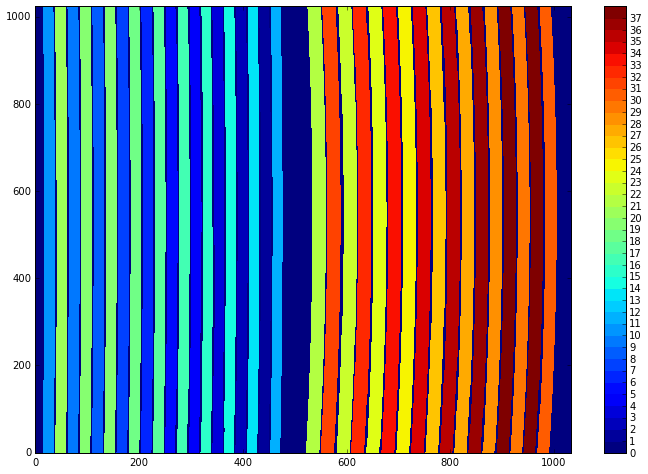

In [130]:
from gwcs import selector
miri_mask = tools.miri_mask()
tools.show(miri_mask.mask, 38)

In [ ]:
#help(selector.RegionsSelector)

In [131]:
miri_models = tools.miri_models()
miri_selector = selector.RegionsSelector(inputs=('x', 'y'), outputs=('ra', 'dec', 'lam'), selector=miri_models, selector_mask=miri_mask)

In [132]:
from gwcs import spectral_builtin_frames
sky = cf.CelestialFrame(coord.ICRS())
spec = cf.SpectralFrame(spectral_builtin_frames.Wavelength())
oframe = cf.CompositeFrame([sky, spec])

ifuwcs = wcs.WCS(output_frame=oframe, forward_transform=miri_selector)

ra, dec, lam = ifuwcs(x, y)


In [108]:
#ifuwcs.output_frame.world_coordinates(ra, dec, lam)


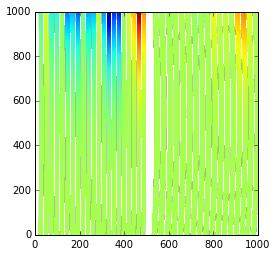

In [133]:
plt.imshow(ra)

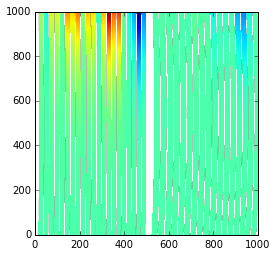

In [134]:
plt.imshow(dec)

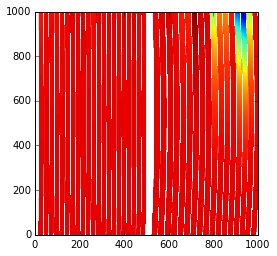

In [137]:
plt.imshow(lam)

In [138]:
slice_22_transform = ifuwcs.forward_transform.set_input(22)
print(slice_22_transform(1, 2))

(-8.459308937851162, -2.3541271491265143, 8.21957644863395)
